# parameter estimation on GW150914 week 3

### Instalization

In [1]:
import bilby # Importing the bilby module for gravitational wave analysis
from gwpy.timeseries import TimeSeries # Importing the TimeSeries class from gwpy.timeseries module

logger = bilby.core.utils.logger # Initializing the logger for logging purposes
outdir = 'outdir'  # Setting the output directory path to 'outdir'
label = 'GW150914' # Setting the label for the analysis as 'GW150914'

### Data Setup

In [2]:
trigger_time = 1126259462 # The trigger time for the analysis

roll_off = 0.4  # Roll off duration of tukey window in seconds, default is 0.4s
duration = 4  # Analysis segment duration (Duration of the analysis segment in seconds)
post_trigger_duration = 2  # Time between trigger time and end of segment
end_time = trigger_time + post_trigger_duration # Calculating the end time of the segment
start_time = end_time - duration # Calculating the start time of the segment

psd_duration = 32 * duration   # Duration of the power spectral density estimation
psd_start_time = start_time - psd_duration  # Calculating the start time of the PSD estimation
psd_end_time = start_time # The end time of the PSD estimation is the same as the start time of the segment

### Download the data

In [3]:
# We now use gwpy to obtain analysis and psd data and create the ifo_list
ifo_list = bilby.gw.detector.InterferometerList([])

# Loop over each detector (H1 and L1)
for det in ["H1", "L1"]:
    logger.info("Downloading analysis data for ifo {}".format(det))

    # Create an empty interferometer object for the detector
    ifo = bilby.gw.detector.get_empty_interferometer(det)

    # Fetch the strain data from gwpy for the specified time interval
    data = TimeSeries.fetch_open_data(det, start_time, end_time)

    # Set the strain data of the interferometer from the gwpy TimeSeries object
    ifo.strain_data.set_from_gwpy_timeseries(data)

    logger.info("Downloading psd data for ifo {}".format(det))

    # Fetch the PSD data from gwpy for the specified time interval
    psd_data = TimeSeries.fetch_open_data(det, psd_start_time, psd_end_time)

    # Calculate the alpha parameter for the Tukey window
    psd_alpha = 2 * roll_off / duration

    # Calculate the PSD using gwpy's psd() method
    psd = psd_data.psd(
        fftlength=duration,
        overlap=0,
        window=("tukey", psd_alpha),
        method="median"
    )

    # Create a PowerSpectralDensity object using the frequency and PSD arrays
    ifo.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value)

    # Append the interferometer object to the ifo_list
    ifo_list.append(ifo)

logger.info("Saving data plots to {}".format(outdir))

# Check if the output directory exists, if not, create it
bilby.core.utils.check_directory_exists_and_if_not_mkdir(outdir)

# Plot the data using the interferometer list and save the plots to the output directory
ifo_list.plot_data(outdir=outdir, label=label)


12:32 bilby INFO    : Downloading analysis data for ifo H1
12:32 bilby INFO    : Downloading psd data for ifo H1
12:32 bilby INFO    : Downloading analysis data for ifo L1
12:32 bilby INFO    : Downloading psd data for ifo L1
12:32 bilby INFO    : Saving data plots to outdir
12:32 bilby INFO    : Generating frequency domain strain from given time domain strain.
12:32 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2
12:32 bilby INFO    : Generating frequency domain strain from given time domain strain.
12:32 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


### Create a prior

In [4]:
# We now define the prior.
# We have defined our prior distribution in a local file, GW150914.prior
# The prior is printed to the terminal at run-time.
# You can overwrite this using the syntax below in the file,
# or choose a fixed value by just providing a float value as the prior.
priors = bilby.gw.prior.BBHPriorDict(filename='GW150914.prior')

### Create a waveform generator

In [5]:
# In this step we define a `waveform_generator`. This is the object which
# creates the frequency-domain strain. In this instance, we are using the
# `lal_binary_black_hole model` source model. We also pass other parameters:
# the waveform approximant and reference frequency and a parameter conversion
# which allows us to sample in chirp mass and ratio rather than component mass
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={'waveform_approximant': 'IMRPhenomPv2',
                        'reference_frequency': 50})

12:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


### Create a likelihood

In [6]:
# In this step, we define the likelihood. Here we use the standard likelihood
# function, passing it the data and the waveform generator.
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    ifo_list, waveform_generator, priors=priors, time_marginalization=True,
    phase_marginalization=True, distance_marginalization=True)

12:36 bilby WARNING : Prior not provided for geocent_time, using the BBH default.
12:36 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.


### Run the analysis

12:37 bilby INFO    : Running for label 'GW150914', output will be saved to 'outdir'
12:37 bilby INFO    : Using lal version 7.2.4
12:37 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
12:37 bilby INFO    : Using lalsimulation version 4.0.2
12:37 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.11;Id: 7a2f2aa176ad39eeaede38f6df4a41d6bf226e8f;;Builder: Unknown User <>;Repository status: CLEAN: All modifications committed
12:37 bilby INFO    : Analysis priors:
12:37 bilby INFO    : mass_ratio=bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None, equal_mass=False)
12:37 bilby INFO    : chirp_mass=bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=35, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)

17918it [00:00, ?it/s]

12:37 bilby INFO    : Written checkpoint file outdir/GW150914_resume.pickle


12:37 bilby INFO    : Rejection sampling nested samples to obtain 4861 posterior samples
12:37 bilby INFO    : Sampling time: 1 day, 22:26:47.188709
12:37 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/4861 [00:00<?, ?it/s]

12:38 bilby INFO    : Reconstructing marginalised parameters.
12:38 bilby INFO    : Cached samples dict out of date, ignoring


  0%|          | 0/4861 [00:00<?, ?it/s]

12:41 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/4861 [00:00<?, ?it/s]

12:41 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/4861 [00:00<?, ?it/s]

12:42 bilby INFO    : Summary of results:
nsamples: 4861
ln_noise_evidence: -20676.586
ln_evidence: -20396.793 +/-  0.137
ln_bayes_factor: 279.793 +/-  0.137



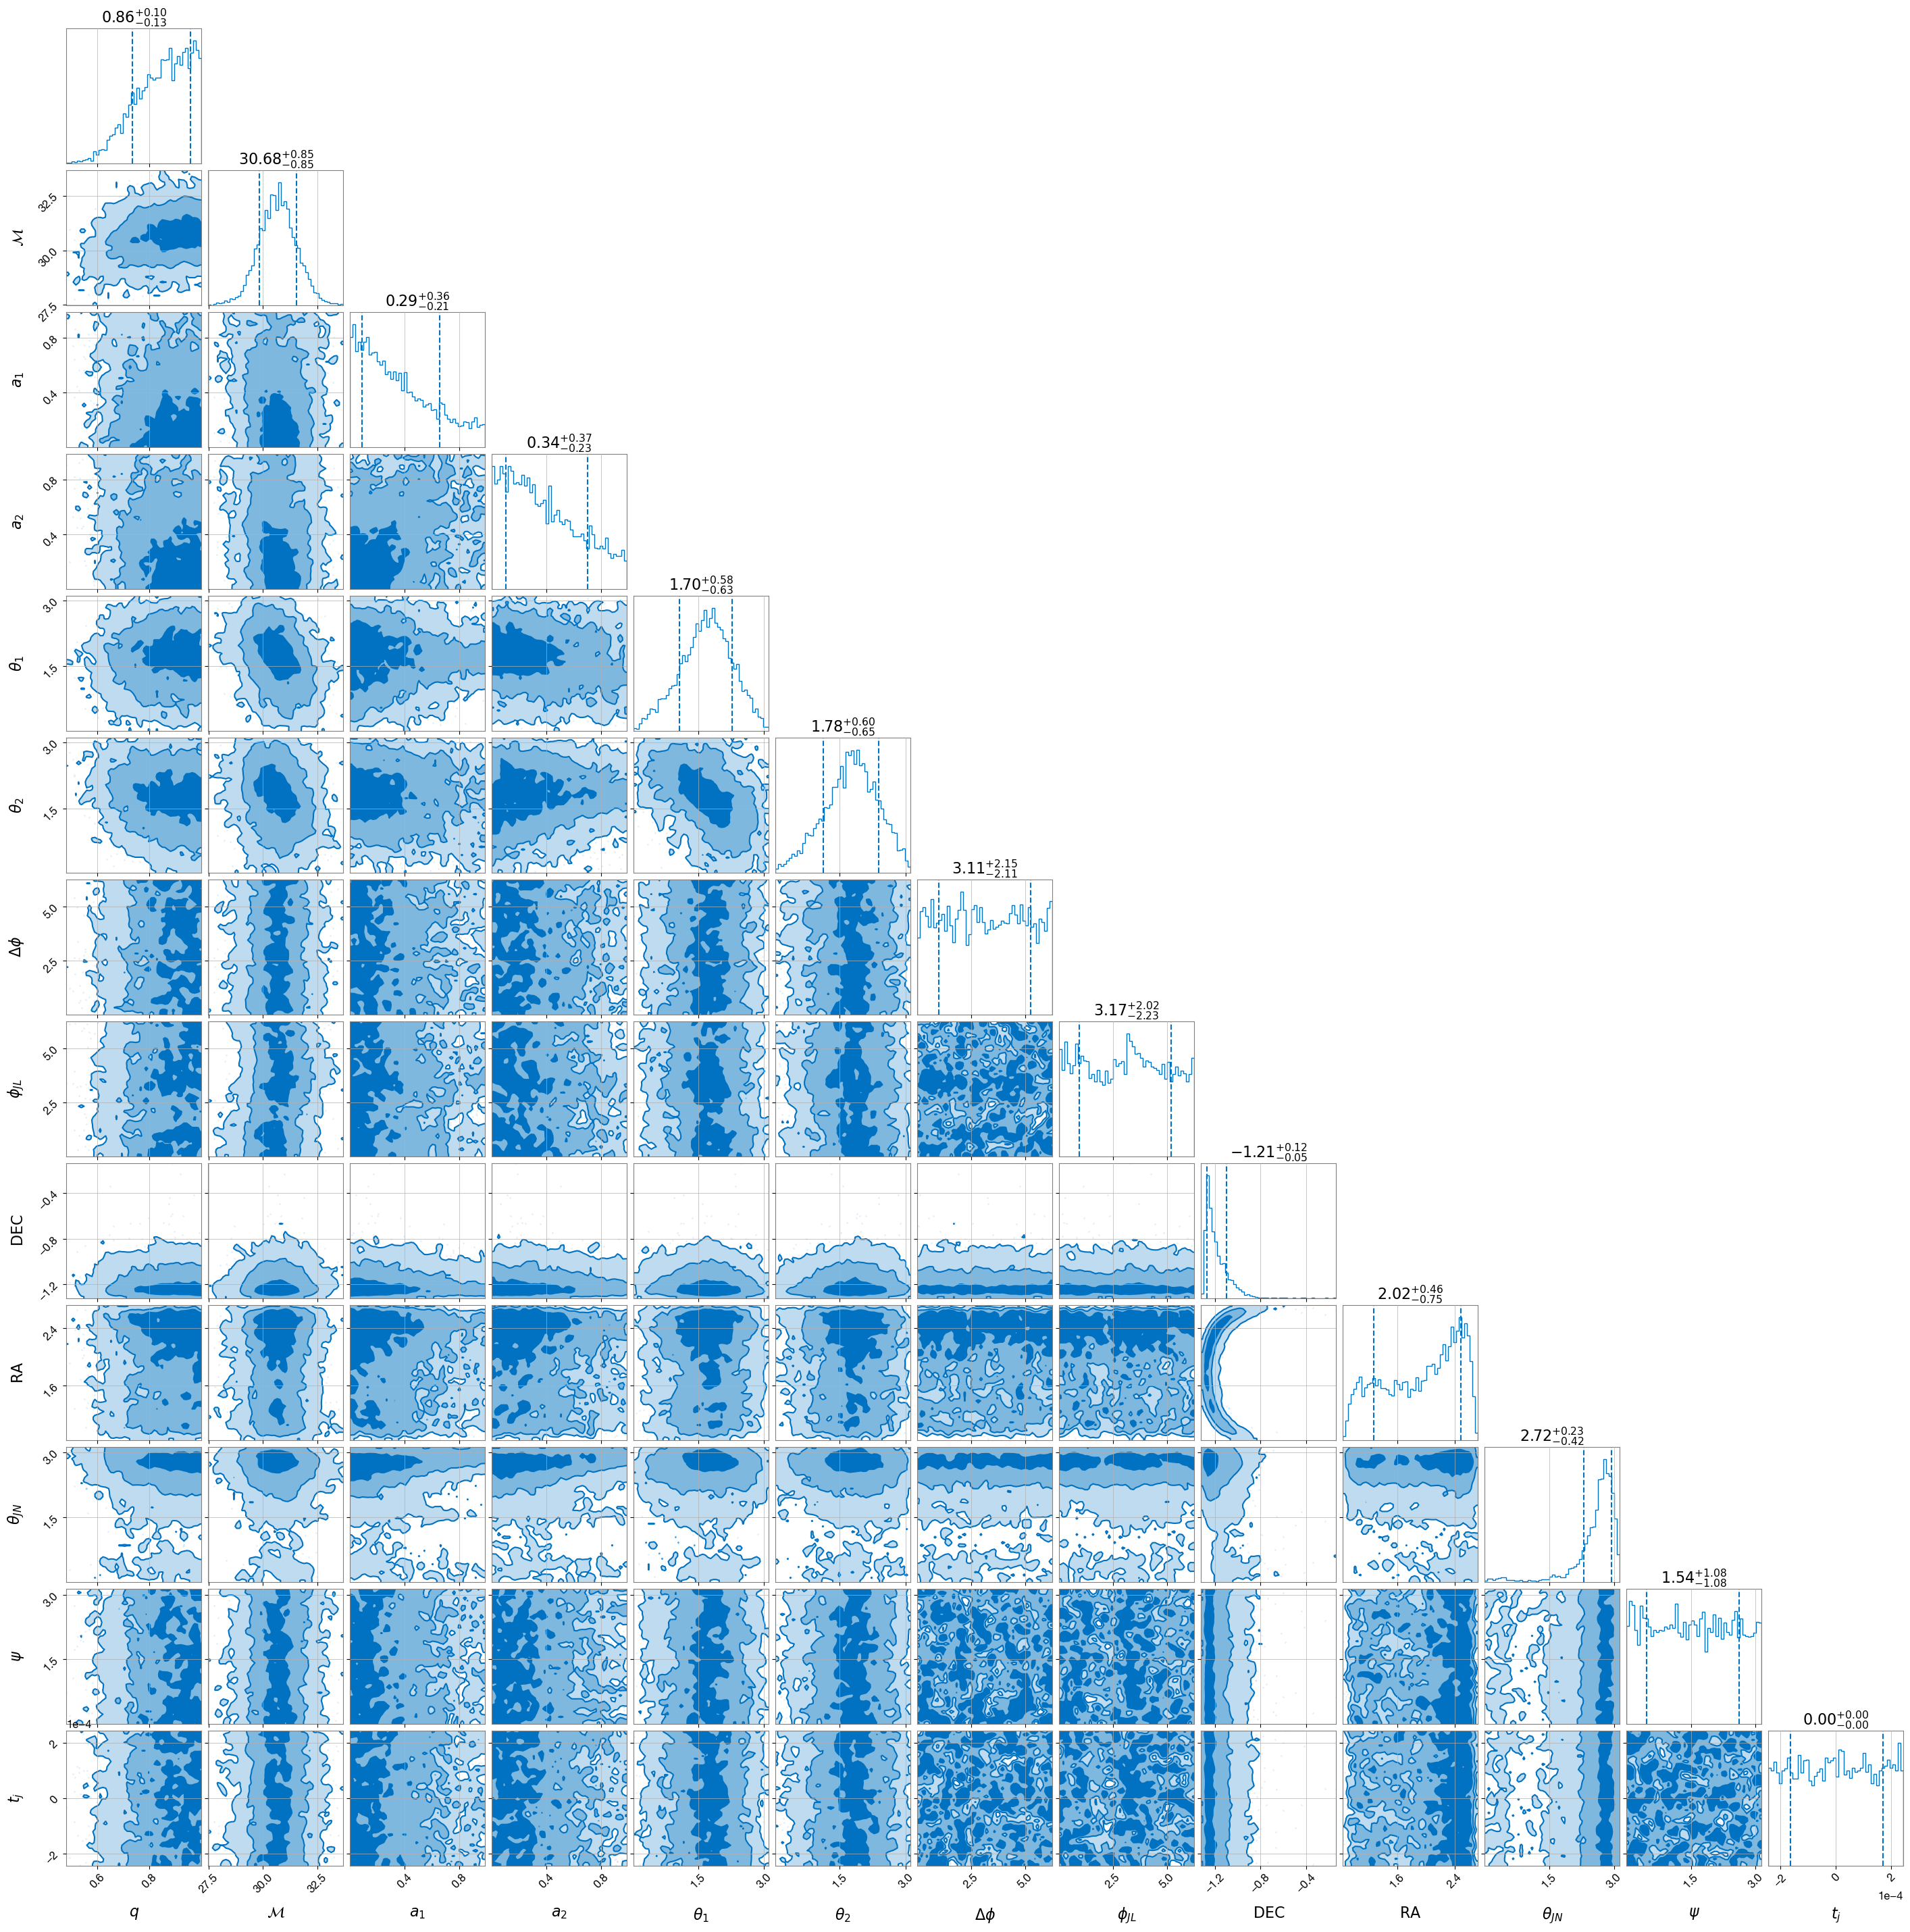

In [7]:
# Finally, we run the sampler. This function takes the likelihood and prior
# along with some options for how to do the sampling and how to save the data
result = bilby.run_sampler(
    likelihood, priors, sampler='dynesty', outdir=outdir, label=label,
    nlive=1000, walks=100, n_check_point=10000, check_point_plot=True,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters)
result.plot_corner()
#256,50,5000,dlogz=0.5